# **Vision Transformer**

# **Image Classification using Vision Transformer**

### **Load Dataset**

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch import nn
import math
import os

In [2]:
# !gdown 1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc

Downloading...
From (original): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
From (redirected): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc&confirm=t&uuid=45777656-fdca-4f5f-8924-48bc18ffe1f2
To: /content/flower_photos.zip
100% 230M/230M [00:02<00:00, 105MB/s]


In [3]:
# !unzip ./flower_photos.zip

Archive:  ./flower_photos.zip
   creating: flower_photos/
   creating: flower_photos/daisy/
  inflating: flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower_photos/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower_photos/daisy/10172567486_2748826a8b.jpg  
  inflating: flower_photos/daisy/10172636503_21bededa75_n.jpg  
  inflating: flower_photos/daisy/102841525_bd6628ae3c.jpg  
  inflating: flower_photos/daisy/1031799732_e7f4008c03.jpg  
  inflating: flower_photos/daisy/10391248763_1d16681106_n.jpg  
  inflating: flower_photos/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flower_photos/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flower_photos/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flower_photos/daisy/10466290366_cc72e33532.jpg  
  inflating: flower_photos/daisy/10466558316_a7198b87e2.jpg  
  inflating: flower_photos/daisy/10555749515_13a12a026e.jpg  
  inflating: flower_photos/daisy/

In [4]:
data_patch = "./flower_photos"

In [5]:
dataset = ImageFolder(root=data_patch)

In [6]:
num_samples = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

In [7]:
TRAIN_RATIO, VALID_RATIO = 0.8, 0.1

n_train_examples = int(num_samples * TRAIN_RATIO)
n_valid_examples = int(num_samples * VALID_RATIO)
n_test_examples = num_samples - n_train_examples - n_valid_examples

In [8]:
train_dataset, valid_dataset, test_dataset = random_split(
    dataset,
    [n_train_examples, n_valid_examples, n_test_examples]
)

### **Preprocessing**

In [9]:
# resize + convert to tensor
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [10]:
train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

### **Dataloader**

In [11]:
BATCH_SIZE = 512

train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE
)

val_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

### **Modeling**

In [12]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_ouput = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

class PatchPositionEmbedding(nn.Module):
    def __init__(self, image_size=224, embed_dim=512, patch_size=16, device="cpu"):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        scale = embed_dim ** -0.5
        self.positional_embedding = nn.Parameter(scale * torch.randn((image_size // patch_size) ** 2, embed_dim))
        self.device = device

    def forward(self, x):
        x = self.conv1(x) # shape [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1) # shape [*, width, grid ** 2]
        x = x.permute(0, 2, 1) # shape [*, grid **2, width]
        x = x + self.positional_embedding.to(self.device)
        return x

In [13]:
class VisionTransformerCls(nn.Module):
    def __init__(self, image_size, embed_dim, num_heads, ff_dim, dropout=0.1, num_classes=10, patch_size=16, device="cpu"):
        super().__init__()
        self.embed_layer = PatchPositionEmbedding(image_size=image_size, embed_dim=embed_dim, patch_size=patch_size, device=device)
        self.transformer_layer = TransformerEncoder(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.embed_layer(x)
        output = self.transformer_layer(output, output, output)
        output = output[:, 0, :]
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [14]:
image_size=224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout=0.1

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
model = VisionTransformerCls(
    image_size=224, embed_dim=512, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, num_classes=num_classes, device=device
)

In [17]:
model.to(device)

VisionTransformerCls(
  (embed_layer): PatchPositionEmbedding(
    (conv1): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16), bias=False)
  )
  (transformer_layer): TransformerEncoder(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (ffn): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=512, bias=True)
    )
    (layernorm_1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
    (layernorm_2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
    (dropout_1): Dropout(p=0.1, inplace=False)
    (dropout_2): Dropout(p=0.1, inplace=False)
  )
  (fc1): Linear(in_features=512, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
)

In [18]:
input, label = next(iter(train_loader))

In [19]:
input = input.to(device)

In [20]:
label

tensor([1, 3, 2, 1, 2, 1, 2, 4, 3, 2, 0, 1, 3, 4, 1, 1, 3, 1, 0, 4, 4, 1, 3, 1,
        1, 3, 0, 3, 1, 3, 3, 3, 3, 4, 3, 3, 1, 1, 4, 0, 3, 0, 1, 4, 2, 0, 3, 4,
        0, 3, 2, 4, 2, 1, 0, 3, 3, 0, 3, 3, 0, 4, 1, 1, 3, 0, 4, 0, 4, 2, 4, 0,
        4, 3, 0, 1, 3, 0, 4, 1, 3, 1, 4, 4, 0, 4, 0, 4, 1, 4, 1, 1, 2, 0, 4, 4,
        2, 3, 2, 2, 0, 3, 3, 1, 3, 2, 4, 4, 1, 2, 0, 1, 1, 3, 1, 0, 1, 1, 4, 3,
        3, 3, 4, 0, 3, 1, 1, 4, 2, 4, 3, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 3, 1,
        0, 0, 4, 3, 4, 2, 3, 1, 2, 4, 0, 1, 1, 3, 1, 1, 4, 0, 1, 4, 2, 0, 1, 4,
        3, 1, 1, 4, 0, 1, 1, 1, 4, 0, 4, 2, 0, 0, 1, 1, 3, 4, 3, 0, 0, 4, 4, 3,
        4, 0, 0, 0, 1, 3, 2, 3, 0, 1, 0, 1, 0, 4, 0, 4, 4, 3, 1, 4, 3, 2, 2, 4,
        0, 3, 2, 3, 2, 1, 2, 2, 4, 3, 3, 3, 3, 0, 1, 0, 4, 2, 1, 0, 2, 1, 2, 1,
        0, 0, 2, 0, 3, 4, 1, 4, 3, 3, 4, 4, 4, 4, 3, 3, 4, 3, 3, 2, 2, 1, 4, 4,
        2, 2, 1, 3, 4, 4, 2, 4, 2, 1, 0, 3, 1, 1, 0, 1, 3, 4, 2, 4, 4, 2, 1, 2,
        4, 4, 4, 3, 4, 2, 4, 4, 0, 4, 4,

In [21]:
predictions = model(input)

In [22]:
predictions

tensor([[ 0.1899,  0.1587,  0.5416,  0.1736,  0.4049],
        [-0.0387,  0.2964, -0.0287,  0.0556,  0.2839],
        [-0.2725,  0.5137, -0.1377,  0.4689,  0.3449],
        ...,
        [-0.0097,  0.2534,  0.0876,  0.2743,  0.4645],
        [ 0.7170,  0.3990,  0.5479, -0.1159, -0.0305],
        [-0.1157,  0.3149,  0.2895,  0.3064,  0.5224]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## **Trainer**

In [23]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [24]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [25]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt', weights_only=True))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

## **Training**

In [26]:
image_size=224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout=0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformerCls(
    image_size=224, embed_dim=512, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, num_classes=num_classes, device=device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 100
save_model = './vit_flowers'
os.makedirs(save_model, exist_ok = True)
model_name = 'vit_flowers'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_loader, val_loader, num_epochs, device
)

-----------------------------------------------------------
| End of epoch   1 | Time: 15.94s | Train Accuracy    0.275 | Train Loss    1.718 | Valid Accuracy    0.403 | Valid Loss    1.441 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   2 | Time: 16.43s | Train Accuracy    0.382 | Train Loss    1.425 | Valid Accuracy    0.420 | Valid Loss    1.336 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   3 | Time: 16.31s | Train Accuracy    0.411 | Train Loss    1.353 | Valid Accuracy    0.455 | Valid Loss    1.241 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   4 | Time: 15.74s | Train Accuracy    0.434 | Train Loss    1.278 | Valid Accuracy    0.469 | Valid Loss    1.199 
--------------------------------------------------------

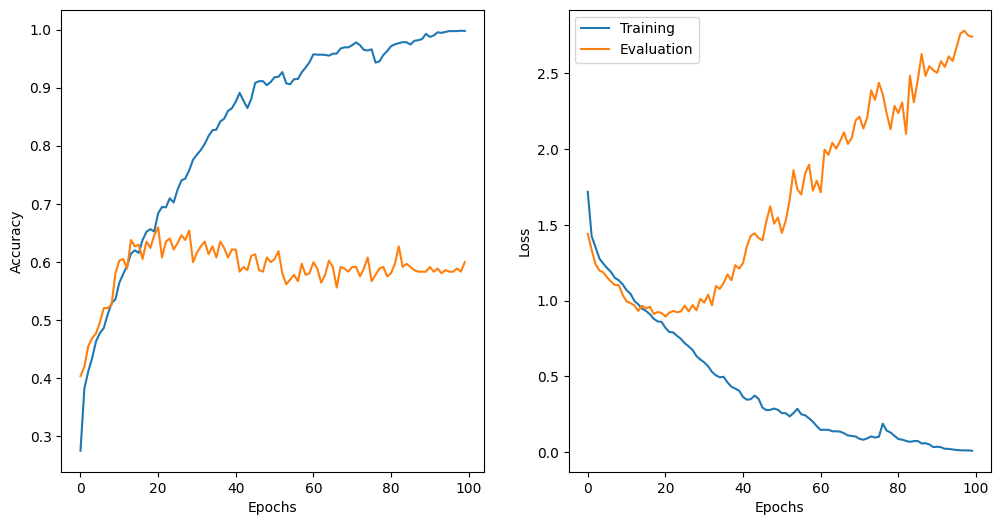

In [27]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [28]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_loader, device)
test_acc, test_loss

(0.5340599455040872, 3.2025651931762695)